In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of kernels in convolutional network
kernel_size1=3
strides=1
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
val_rate = 0.1
test_rate=0.1 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating input dataset - mask
mask_dir = main_directory + '\\aeroCNN2Mask'
os.chdir(mask_dir)
mask_list = os.listdir(mask_dir)
mask_target = [file for file in mask_list if file.endswith('.csv')]

In [8]:
mask_df = pd.DataFrame()
for file in mask_target:
    data = pd.read_csv(file, header=None)
    mask_df = pd.concat([mask_df, data], axis=0)

In [9]:
x = mask_df.iloc[:,:].values

In [10]:
x_alligned = np.zeros((x.shape[0],x.shape[1]))
for i in range(0,144*2):
    if i%2==0:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:]
    else:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:].T


In [11]:
x = x_alligned.reshape((16*9,2,input_size,input_size))

In [12]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]
os.chdir(main_directory)

In [13]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [14]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [15]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [16]:
y.shape

(144, 2)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_rate, random_state=1)

In [19]:
x_train.shape

(116, 2, 100, 100)

In [20]:
y_train.shape

(116, 2)

In [21]:
tf.keras.backend.set_image_data_format('channels_first')

In [22]:
input_image = tf.keras.Input(shape=(2, input_size, input_size))

x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_flat = tf.keras.layers.Flatten()(x_)
x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_flat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=16, activation='relu', name='fc4')(x_fc3)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc4)
# AeroCNN-II based
model = tf.keras.Model(input_image, output_data)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 100, 100)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 100, 100)     3800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 200, 50, 50)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 fc1 (Dense)                 (None, 128)               64000128  
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                             

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [26]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [27]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 15s 392ms/step - loss: 1224.6671 - rmse: 34.9952 - val_loss: 89.1689 - val_rmse: 9.4429 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 55ms/step - loss: 68.3286 - rmse: 8.2661 - val_loss: 60.4375 - val_rmse: 7.7742 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 51ms/step - loss: 44.1195 - rmse: 6.6423 - val_loss: 16.6266 - val_rmse: 4.0776 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 50ms/step - loss: 19.7583 - rmse: 4.4450 - val_loss: 8.8942 - val_rmse: 2.9823 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 50ms/step - loss: 11.4781 - rmse: 3.3879 - val_loss: 8.0697 - val_rmse: 2.8407 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 50ms/step - loss: 7.3946 - rmse: 2.7193 - val_loss: 5.1435 - val_rmse: 2.2679 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 44ms/step - loss: 6.7758 - rmse: 2.6030 - val_loss: 1.29

Epoch 57/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0496 - rmse: 0.2226 - val_loss: 0.1299 - val_rmse: 0.3605 - lr: 0.0010
Epoch 58/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0564 - rmse: 0.2376 - val_loss: 0.1851 - val_rmse: 0.4303 - lr: 0.0010
Epoch 59/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0521 - rmse: 0.2282 - val_loss: 0.1690 - val_rmse: 0.4111 - lr: 0.0010
Epoch 60/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0444 - rmse: 0.2107 - val_loss: 0.2618 - val_rmse: 0.5117 - lr: 0.0010
Epoch 61/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0467 - rmse: 0.2161 - val_loss: 0.1228 - val_rmse: 0.3504 - lr: 0.0010
Epoch 62/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.0509 - rmse: 0.2255 - val_loss: 0.1150 - val_rmse: 0.3392 - lr: 0.0010
Epoch 63/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0540 - rmse: 0.2324 - val_loss: 0.1197 - v

Epoch 113/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0429 - rmse: 0.2072 - val_loss: 0.1032 - val_rmse: 0.3213 - lr: 0.0010
Epoch 114/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0235 - rmse: 0.1534 - val_loss: 0.1284 - val_rmse: 0.3583 - lr: 0.0010
Epoch 115/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.0238 - rmse: 0.1543 - val_loss: 0.0962 - val_rmse: 0.3102 - lr: 0.0010
Epoch 116/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0716 - val_rmse: 0.2676 - lr: 0.0010
Epoch 117/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0142 - rmse: 0.1190 - val_loss: 0.0893 - val_rmse: 0.2988 - lr: 0.0010
Epoch 118/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0240 - rmse: 0.1548 - val_loss: 0.1307 - val_rmse: 0.3616 - lr: 0.0010
Epoch 119/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0242 - rmse: 0.1555 - val_loss: 0.1

5/5 [==============================] - 0s 18ms/step - loss: 0.3652 - rmse: 0.6044 - val_loss: 0.3152 - val_rmse: 0.5614 - lr: 0.0010
Epoch 169/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.2801 - rmse: 0.5293 - val_loss: 0.1193 - val_rmse: 0.3453 - lr: 0.0010
Epoch 170/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.2462 - rmse: 0.4961 - val_loss: 0.8143 - val_rmse: 0.9024 - lr: 0.0010
Epoch 171/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2932 - rmse: 0.5415 - val_loss: 0.1698 - val_rmse: 0.4121 - lr: 0.0010
Epoch 172/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2262 - rmse: 0.4756 - val_loss: 0.5052 - val_rmse: 0.7108 - lr: 0.0010
Epoch 173/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.4692 - rmse: 0.6850 - val_loss: 0.9359 - val_rmse: 0.9674 - lr: 0.0010
Epoch 174/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.6273 - rmse: 0.7920 - val_loss: 0.6268 - val_rmse:

5/5 [==============================] - 0s 18ms/step - loss: 0.0120 - rmse: 0.1093 - val_loss: 0.0589 - val_rmse: 0.2428 - lr: 5.0000e-04
Epoch 223/5000
5/5 [==============================] - 0s 43ms/step - loss: 0.0107 - rmse: 0.1032 - val_loss: 0.0600 - val_rmse: 0.2449 - lr: 5.0000e-04
Epoch 224/5000
5/5 [==============================] - 0s 44ms/step - loss: 0.0106 - rmse: 0.1027 - val_loss: 0.0409 - val_rmse: 0.2023 - lr: 5.0000e-04
Epoch 225/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0111 - rmse: 0.1054 - val_loss: 0.0529 - val_rmse: 0.2299 - lr: 5.0000e-04
Epoch 226/5000
5/5 [==============================] - 0s 43ms/step - loss: 0.0056 - rmse: 0.0749 - val_loss: 0.0600 - val_rmse: 0.2450 - lr: 5.0000e-04
Epoch 227/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0060 - rmse: 0.0774 - val_loss: 0.0428 - val_rmse: 0.2068 - lr: 5.0000e-04
Epoch 228/5000
5/5 [==============================] - 0s 43ms/step - loss: 0.0041 - rmse: 0.0642 - val_

Epoch 276/5000
5/5 [==============================] - 0s 18ms/step - loss: 5.4583e-04 - rmse: 0.0234 - val_loss: 0.0515 - val_rmse: 0.2269 - lr: 5.0000e-04
Epoch 277/5000
5/5 [==============================] - 0s 18ms/step - loss: 9.2044e-04 - rmse: 0.0303 - val_loss: 0.0539 - val_rmse: 0.2322 - lr: 5.0000e-04
Epoch 278/5000
5/5 [==============================] - 0s 19ms/step - loss: 6.3691e-04 - rmse: 0.0252 - val_loss: 0.0540 - val_rmse: 0.2323 - lr: 5.0000e-04
Epoch 279/5000
5/5 [==============================] - 0s 18ms/step - loss: 9.2531e-04 - rmse: 0.0304 - val_loss: 0.0625 - val_rmse: 0.2500 - lr: 5.0000e-04
Epoch 280/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - rmse: 0.0346 - val_loss: 0.0594 - val_rmse: 0.2436 - lr: 5.0000e-04
Epoch 281/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.0011 - rmse: 0.0331 - val_loss: 0.0600 - val_rmse: 0.2450 - lr: 5.0000e-04
Epoch 282/5000
5/5 [==============================] - 0s 18ms/step - los

5/5 [==============================] - 0s 18ms/step - loss: 6.6570e-04 - rmse: 0.0258 - val_loss: 0.0589 - val_rmse: 0.2426 - lr: 5.0000e-04
Epoch 330/5000
5/5 [==============================] - 0s 18ms/step - loss: 9.2225e-04 - rmse: 0.0304 - val_loss: 0.0578 - val_rmse: 0.2404 - lr: 5.0000e-04
Epoch 331/5000
5/5 [==============================] - 0s 19ms/step - loss: 8.5362e-04 - rmse: 0.0292 - val_loss: 0.0570 - val_rmse: 0.2388 - lr: 5.0000e-04
Epoch 332/5000
5/5 [==============================] - 0s 19ms/step - loss: 8.7255e-04 - rmse: 0.0295 - val_loss: 0.0585 - val_rmse: 0.2419 - lr: 5.0000e-04
Epoch 333/5000
5/5 [==============================] - 0s 18ms/step - loss: 9.1289e-04 - rmse: 0.0302 - val_loss: 0.0592 - val_rmse: 0.2434 - lr: 5.0000e-04
Epoch 334/5000
5/5 [==============================] - 0s 18ms/step - loss: 7.3681e-04 - rmse: 0.0271 - val_loss: 0.0615 - val_rmse: 0.2481 - lr: 5.0000e-04
Epoch 335/5000
5/5 [==============================] - 0s 18ms/step - loss: 9.77

5/5 [==============================] - 0s 18ms/step - loss: 6.6957e-04 - rmse: 0.0259 - val_loss: 0.0609 - val_rmse: 0.2469 - lr: 2.5000e-04
Epoch 382/5000
5/5 [==============================] - 0s 18ms/step - loss: 8.3494e-04 - rmse: 0.0289 - val_loss: 0.0586 - val_rmse: 0.2421 - lr: 2.5000e-04
Epoch 383/5000
5/5 [==============================] - 0s 18ms/step - loss: 6.3936e-04 - rmse: 0.0253 - val_loss: 0.0583 - val_rmse: 0.2416 - lr: 2.5000e-04
Epoch 384/5000
5/5 [==============================] - 0s 18ms/step - loss: 6.0792e-04 - rmse: 0.0247 - val_loss: 0.0604 - val_rmse: 0.2458 - lr: 2.5000e-04
Epoch 385/5000
5/5 [==============================] - 0s 18ms/step - loss: 5.9044e-04 - rmse: 0.0243 - val_loss: 0.0582 - val_rmse: 0.2411 - lr: 2.5000e-04
Epoch 386/5000
5/5 [==============================] - 0s 18ms/step - loss: 7.6531e-04 - rmse: 0.0277 - val_loss: 0.0533 - val_rmse: 0.2308 - lr: 2.5000e-04
Epoch 387/5000
5/5 [==============================] - 0s 18ms/step - loss: 8.31

Epoch 434/5000
5/5 [==============================] - 0s 19ms/step - loss: 5.5172e-04 - rmse: 0.0235 - val_loss: 0.0659 - val_rmse: 0.2567 - lr: 2.5000e-04
Epoch 435/5000
5/5 [==============================] - 0s 18ms/step - loss: 6.7723e-04 - rmse: 0.0260 - val_loss: 0.0633 - val_rmse: 0.2517 - lr: 2.5000e-04
Epoch 436/5000
5/5 [==============================] - 0s 18ms/step - loss: 5.8876e-04 - rmse: 0.0243 - val_loss: 0.0553 - val_rmse: 0.2351 - lr: 2.5000e-04
Epoch 437/5000
5/5 [==============================] - 0s 18ms/step - loss: 8.5812e-04 - rmse: 0.0293 - val_loss: 0.0542 - val_rmse: 0.2329 - lr: 2.5000e-04
Epoch 438/5000
5/5 [==============================] - 0s 18ms/step - loss: 7.4195e-04 - rmse: 0.0272 - val_loss: 0.0654 - val_rmse: 0.2558 - lr: 2.5000e-04
Epoch 439/5000
5/5 [==============================] - 0s 19ms/step - loss: 7.8098e-04 - rmse: 0.0279 - val_loss: 0.0660 - val_rmse: 0.2568 - lr: 2.5000e-04
Epoch 440/5000
5/5 [==============================] - 0s 19ms/st

5/5 [==============================] - 0s 18ms/step - loss: 6.8066e-04 - rmse: 0.0261 - val_loss: 0.0643 - val_rmse: 0.2537 - lr: 2.5000e-04
Epoch 487/5000
5/5 [==============================] - 0s 19ms/step - loss: 9.7590e-04 - rmse: 0.0312 - val_loss: 0.0610 - val_rmse: 0.2471 - lr: 2.5000e-04
Epoch 488/5000
5/5 [==============================] - 0s 19ms/step - loss: 9.2551e-04 - rmse: 0.0304 - val_loss: 0.0555 - val_rmse: 0.2355 - lr: 2.5000e-04
Epoch 489/5000
5/5 [==============================] - 0s 18ms/step - loss: 6.7506e-04 - rmse: 0.0260 - val_loss: 0.0564 - val_rmse: 0.2376 - lr: 2.5000e-04
Epoch 490/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.9696e-04 - rmse: 0.0199 - val_loss: 0.0567 - val_rmse: 0.2381 - lr: 2.5000e-04
Epoch 491/5000
5/5 [==============================] - 0s 18ms/step - loss: 4.9116e-04 - rmse: 0.0222 - val_loss: 0.0647 - val_rmse: 0.2543 - lr: 2.5000e-04
Epoch 492/5000
5/5 [==============================] - 0s 18ms/step - loss: 7.22

Epoch 538/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.5099e-04 - rmse: 0.0187 - val_loss: 0.0618 - val_rmse: 0.2486 - lr: 1.2500e-04
Epoch 539/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.9161e-04 - rmse: 0.0198 - val_loss: 0.0628 - val_rmse: 0.2505 - lr: 1.2500e-04
Epoch 540/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1369e-04 - rmse: 0.0177 - val_loss: 0.0622 - val_rmse: 0.2494 - lr: 1.2500e-04
Epoch 541/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.6743e-04 - rmse: 0.0192 - val_loss: 0.0618 - val_rmse: 0.2486 - lr: 1.2500e-04
Epoch 542/5000
5/5 [==============================] - 0s 18ms/step - loss: 4.5724e-04 - rmse: 0.0214 - val_loss: 0.0614 - val_rmse: 0.2478 - lr: 1.2500e-04
Epoch 543/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1300e-04 - rmse: 0.0177 - val_loss: 0.0614 - val_rmse: 0.2478 - lr: 1.2500e-04
Epoch 544/5000
5/5 [==============================] - 0s 18ms/st

5/5 [==============================] - 0s 19ms/step - loss: 2.7741e-04 - rmse: 0.0167 - val_loss: 0.0637 - val_rmse: 0.2525 - lr: 1.2500e-04
Epoch 591/5000
5/5 [==============================] - 0s 18ms/step - loss: 4.2117e-04 - rmse: 0.0205 - val_loss: 0.0602 - val_rmse: 0.2454 - lr: 1.2500e-04
Epoch 592/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.3086e-04 - rmse: 0.0182 - val_loss: 0.0598 - val_rmse: 0.2446 - lr: 1.2500e-04
Epoch 593/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.3263e-04 - rmse: 0.0182 - val_loss: 0.0612 - val_rmse: 0.2473 - lr: 1.2500e-04
Epoch 594/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.8644e-04 - rmse: 0.0197 - val_loss: 0.0583 - val_rmse: 0.2415 - lr: 1.2500e-04
Epoch 595/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.6081e-04 - rmse: 0.0190 - val_loss: 0.0580 - val_rmse: 0.2408 - lr: 1.2500e-04
Epoch 596/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.37

Epoch 643/5000
5/5 [==============================] - 0s 18ms/step - loss: 4.2873e-04 - rmse: 0.0207 - val_loss: 0.0605 - val_rmse: 0.2459 - lr: 1.2500e-04
Epoch 644/5000
5/5 [==============================] - 0s 19ms/step - loss: 4.2081e-04 - rmse: 0.0205 - val_loss: 0.0585 - val_rmse: 0.2419 - lr: 1.2500e-04
Epoch 645/5000
5/5 [==============================] - 0s 18ms/step - loss: 5.5209e-04 - rmse: 0.0235 - val_loss: 0.0638 - val_rmse: 0.2525 - lr: 1.2500e-04
Epoch 646/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.8412e-04 - rmse: 0.0196 - val_loss: 0.0614 - val_rmse: 0.2478 - lr: 1.2500e-04
Epoch 647/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7777e-04 - rmse: 0.0167 - val_loss: 0.0607 - val_rmse: 0.2464 - lr: 1.2500e-04
Epoch 648/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1869e-04 - rmse: 0.0179 - val_loss: 0.0618 - val_rmse: 0.2487 - lr: 1.2500e-04
Epoch 649/5000
5/5 [==============================] - 0s 19ms/st

5/5 [==============================] - 0s 18ms/step - loss: 3.3852e-04 - rmse: 0.0184 - val_loss: 0.0619 - val_rmse: 0.2488 - lr: 6.2500e-05
Epoch 695/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.9792e-04 - rmse: 0.0173 - val_loss: 0.0615 - val_rmse: 0.2480 - lr: 6.2500e-05
Epoch 696/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1109e-04 - rmse: 0.0176 - val_loss: 0.0610 - val_rmse: 0.2471 - lr: 6.2500e-05
Epoch 697/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.7293e-04 - rmse: 0.0165 - val_loss: 0.0615 - val_rmse: 0.2480 - lr: 6.2500e-05
Epoch 698/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.3508e-04 - rmse: 0.0183 - val_loss: 0.0635 - val_rmse: 0.2519 - lr: 6.2500e-05
Epoch 699/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.2041e-04 - rmse: 0.0179 - val_loss: 0.0637 - val_rmse: 0.2524 - lr: 6.2500e-05
Epoch 700/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.03

Epoch 747/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.8926e-04 - rmse: 0.0170 - val_loss: 0.0613 - val_rmse: 0.2476 - lr: 6.2500e-05
Epoch 748/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.3148e-04 - rmse: 0.0182 - val_loss: 0.0621 - val_rmse: 0.2493 - lr: 6.2500e-05
Epoch 749/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1169e-04 - rmse: 0.0177 - val_loss: 0.0605 - val_rmse: 0.2459 - lr: 6.2500e-05
Epoch 750/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.7651e-04 - rmse: 0.0194 - val_loss: 0.0606 - val_rmse: 0.2461 - lr: 6.2500e-05
Epoch 751/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.5749e-04 - rmse: 0.0189 - val_loss: 0.0626 - val_rmse: 0.2503 - lr: 6.2500e-05
Epoch 752/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.5731e-04 - rmse: 0.0189 - val_loss: 0.0604 - val_rmse: 0.2459 - lr: 6.2500e-05
Epoch 753/5000
5/5 [==============================] - 0s 18ms/st

5/5 [==============================] - 0s 19ms/step - loss: 3.6680e-04 - rmse: 0.0192 - val_loss: 0.0615 - val_rmse: 0.2479 - lr: 6.2500e-05
Epoch 800/5000
5/5 [==============================] - 0s 19ms/step - loss: 4.1511e-04 - rmse: 0.0204 - val_loss: 0.0628 - val_rmse: 0.2505 - lr: 6.2500e-05
Epoch 801/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.9388e-04 - rmse: 0.0171 - val_loss: 0.0632 - val_rmse: 0.2514 - lr: 6.2500e-05
Epoch 802/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1828e-04 - rmse: 0.0178 - val_loss: 0.0613 - val_rmse: 0.2475 - lr: 6.2500e-05
Epoch 803/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1312e-04 - rmse: 0.0177 - val_loss: 0.0633 - val_rmse: 0.2517 - lr: 6.2500e-05
Epoch 804/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.3382e-04 - rmse: 0.0183 - val_loss: 0.0632 - val_rmse: 0.2515 - lr: 6.2500e-05
Epoch 805/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.01

5/5 [==============================] - 0s 18ms/step - loss: 2.2071e-04 - rmse: 0.0149 - val_loss: 0.0631 - val_rmse: 0.2512 - lr: 3.1250e-05
Epoch 851/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.8015e-04 - rmse: 0.0167 - val_loss: 0.0606 - val_rmse: 0.2461 - lr: 3.1250e-05
Epoch 852/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.8378e-04 - rmse: 0.0168 - val_loss: 0.0610 - val_rmse: 0.2469 - lr: 3.1250e-05
Epoch 853/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.2335e-04 - rmse: 0.0149 - val_loss: 0.0634 - val_rmse: 0.2519 - lr: 3.1250e-05
Epoch 854/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.2482e-04 - rmse: 0.0150 - val_loss: 0.0629 - val_rmse: 0.2509 - lr: 3.1250e-05
Epoch 855/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.8798e-04 - rmse: 0.0170 - val_loss: 0.0636 - val_rmse: 0.2522 - lr: 3.1250e-05
Epoch 856/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.93

Epoch 903/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7829e-04 - rmse: 0.0167 - val_loss: 0.0611 - val_rmse: 0.2472 - lr: 3.1250e-05
Epoch 904/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.0820e-04 - rmse: 0.0144 - val_loss: 0.0628 - val_rmse: 0.2506 - lr: 3.1250e-05
Epoch 905/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1763e-04 - rmse: 0.0178 - val_loss: 0.0632 - val_rmse: 0.2514 - lr: 3.1250e-05
Epoch 906/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.1685e-04 - rmse: 0.0178 - val_loss: 0.0636 - val_rmse: 0.2521 - lr: 3.1250e-05
Epoch 907/5000
5/5 [==============================] - 0s 19ms/step - loss: 3.5755e-04 - rmse: 0.0189 - val_loss: 0.0615 - val_rmse: 0.2479 - lr: 3.1250e-05
Epoch 908/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.7841e-04 - rmse: 0.0195 - val_loss: 0.0625 - val_rmse: 0.2500 - lr: 3.1250e-05
Epoch 909/5000
5/5 [==============================] - 0s 18ms/st

5/5 [==============================] - 0s 19ms/step - loss: 2.8242e-04 - rmse: 0.0168 - val_loss: 0.0622 - val_rmse: 0.2494 - lr: 3.1250e-05
Epoch 956/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.5965e-04 - rmse: 0.0161 - val_loss: 0.0628 - val_rmse: 0.2505 - lr: 3.1250e-05
Epoch 957/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.9425e-04 - rmse: 0.0172 - val_loss: 0.0627 - val_rmse: 0.2505 - lr: 3.1250e-05
Epoch 958/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7071e-04 - rmse: 0.0165 - val_loss: 0.0633 - val_rmse: 0.2517 - lr: 3.1250e-05
Epoch 959/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.8433e-04 - rmse: 0.0136 - val_loss: 0.0646 - val_rmse: 0.2541 - lr: 3.1250e-05
Epoch 960/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.2906e-04 - rmse: 0.0181 - val_loss: 0.0632 - val_rmse: 0.2514 - lr: 3.1250e-05
Epoch 961/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.47

5/5 [==============================] - 0s 18ms/step - loss: 1.9157e-04 - rmse: 0.0138 - val_loss: 0.0620 - val_rmse: 0.2489 - lr: 1.5625e-05
Epoch 1007/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.5372e-04 - rmse: 0.0159 - val_loss: 0.0610 - val_rmse: 0.2469 - lr: 1.5625e-05
Epoch 1008/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.8490e-04 - rmse: 0.0169 - val_loss: 0.0622 - val_rmse: 0.2495 - lr: 1.5625e-05
Epoch 1009/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.1235e-04 - rmse: 0.0146 - val_loss: 0.0627 - val_rmse: 0.2505 - lr: 1.5625e-05
Epoch 1010/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.9842e-04 - rmse: 0.0173 - val_loss: 0.0634 - val_rmse: 0.2517 - lr: 1.5625e-05
Epoch 1011/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.4274e-04 - rmse: 0.0185 - val_loss: 0.0622 - val_rmse: 0.2494 - lr: 1.5625e-05
Epoch 1012/5000
5/5 [==============================] - 0s 18ms/step - loss

5/5 [==============================] - 0s 18ms/step - loss: 2.2971e-04 - rmse: 0.0152 - val_loss: 0.0625 - val_rmse: 0.2500 - lr: 1.5625e-05
Epoch 1059/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7269e-04 - rmse: 0.0165 - val_loss: 0.0625 - val_rmse: 0.2500 - lr: 1.5625e-05
Epoch 1060/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.3072e-04 - rmse: 0.0152 - val_loss: 0.0620 - val_rmse: 0.2490 - lr: 1.5625e-05
Epoch 1061/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.5611e-04 - rmse: 0.0160 - val_loss: 0.0632 - val_rmse: 0.2514 - lr: 1.5625e-05
Epoch 1062/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.3054e-04 - rmse: 0.0152 - val_loss: 0.0634 - val_rmse: 0.2517 - lr: 1.5625e-05
Epoch 1063/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.4842e-04 - rmse: 0.0158 - val_loss: 0.0633 - val_rmse: 0.2515 - lr: 1.5625e-05
Epoch 1064/5000
5/5 [==============================] - 0s 19ms/step - loss

5/5 [==============================] - 0s 18ms/step - loss: 2.7737e-04 - rmse: 0.0167 - val_loss: 0.0614 - val_rmse: 0.2478 - lr: 1.5625e-05
Epoch 1111/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.8055e-04 - rmse: 0.0167 - val_loss: 0.0615 - val_rmse: 0.2480 - lr: 1.5625e-05
Epoch 1112/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.8180e-04 - rmse: 0.0168 - val_loss: 0.0613 - val_rmse: 0.2475 - lr: 1.5625e-05
Epoch 1113/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.8827e-04 - rmse: 0.0137 - val_loss: 0.0627 - val_rmse: 0.2505 - lr: 1.5625e-05
Epoch 1114/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.0005e-04 - rmse: 0.0173 - val_loss: 0.0598 - val_rmse: 0.2445 - lr: 1.5625e-05
Epoch 1115/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.7944e-04 - rmse: 0.0134 - val_loss: 0.0604 - val_rmse: 0.2458 - lr: 1.5625e-05
Epoch 1116/5000
5/5 [==============================] - 0s 18ms/step - loss

5/5 [==============================] - 0s 18ms/step - loss: 2.4923e-04 - rmse: 0.0158 - val_loss: 0.0611 - val_rmse: 0.2473 - lr: 7.8125e-06
Epoch 1162/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.5641e-04 - rmse: 0.0160 - val_loss: 0.0618 - val_rmse: 0.2486 - lr: 7.8125e-06
Epoch 1163/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.3654e-04 - rmse: 0.0154 - val_loss: 0.0616 - val_rmse: 0.2481 - lr: 7.8125e-06
Epoch 1164/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.8415e-04 - rmse: 0.0136 - val_loss: 0.0614 - val_rmse: 0.2478 - lr: 7.8125e-06
Epoch 1165/5000
5/5 [==============================] - 0s 19ms/step - loss: 1.9324e-04 - rmse: 0.0139 - val_loss: 0.0613 - val_rmse: 0.2476 - lr: 7.8125e-06
Epoch 1166/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.3838e-04 - rmse: 0.0154 - val_loss: 0.0615 - val_rmse: 0.2481 - lr: 7.8125e-06
Epoch 1167/5000
5/5 [==============================] - 0s 44ms/step - loss

5/5 [==============================] - 0s 19ms/step - loss: 2.6949e-04 - rmse: 0.0164 - val_loss: 0.0604 - val_rmse: 0.2457 - lr: 7.8125e-06
Epoch 1214/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.8262e-04 - rmse: 0.0168 - val_loss: 0.0610 - val_rmse: 0.2469 - lr: 7.8125e-06
Epoch 1215/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.4994e-04 - rmse: 0.0158 - val_loss: 0.0611 - val_rmse: 0.2471 - lr: 7.8125e-06
Epoch 1216/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.6203e-04 - rmse: 0.0127 - val_loss: 0.0630 - val_rmse: 0.2511 - lr: 7.8125e-06
Epoch 1217/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.9357e-04 - rmse: 0.0171 - val_loss: 0.0621 - val_rmse: 0.2492 - lr: 7.8125e-06
Epoch 1218/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.0698e-04 - rmse: 0.0144 - val_loss: 0.0621 - val_rmse: 0.2491 - lr: 7.8125e-06
Epoch 1219/5000
5/5 [==============================] - 0s 19ms/step - loss

5/5 [==============================] - 0s 18ms/step - loss: 2.2912e-04 - rmse: 0.0151 - val_loss: 0.0604 - val_rmse: 0.2458 - lr: 7.8125e-06
Epoch 1266/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7739e-04 - rmse: 0.0167 - val_loss: 0.0613 - val_rmse: 0.2476 - lr: 7.8125e-06
Epoch 1267/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7029e-04 - rmse: 0.0164 - val_loss: 0.0627 - val_rmse: 0.2505 - lr: 7.8125e-06
Epoch 1268/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7300e-04 - rmse: 0.0165 - val_loss: 0.0601 - val_rmse: 0.2452 - lr: 7.8125e-06
Epoch 1269/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.2594e-04 - rmse: 0.0181 - val_loss: 0.0618 - val_rmse: 0.2485 - lr: 7.8125e-06
Epoch 1270/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.3583e-04 - rmse: 0.0154 - val_loss: 0.0621 - val_rmse: 0.2491 - lr: 7.8125e-06
Epoch 1271/5000
5/5 [==============================] - 0s 18ms/step - loss

5/5 [==============================] - 0s 18ms/step - loss: 2.3558e-04 - rmse: 0.0153 - val_loss: 0.0600 - val_rmse: 0.2449 - lr: 7.8125e-06
Epoch 1318/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.9543e-04 - rmse: 0.0140 - val_loss: 0.0627 - val_rmse: 0.2504 - lr: 7.8125e-06
Epoch 1319/5000
5/5 [==============================] - 0s 20ms/step - loss: 2.2615e-04 - rmse: 0.0150 - val_loss: 0.0615 - val_rmse: 0.2479 - lr: 7.8125e-06
Epoch 1320/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.4948e-04 - rmse: 0.0122 - val_loss: 0.0607 - val_rmse: 0.2463 - lr: 7.8125e-06
Epoch 1321/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.2031e-04 - rmse: 0.0148 - val_loss: 0.0614 - val_rmse: 0.2478 - lr: 7.8125e-06
Epoch 1322/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.0883e-04 - rmse: 0.0145 - val_loss: 0.0582 - val_rmse: 0.2413 - lr: 7.8125e-06
Epoch 1323/5000
5/5 [==============================] - 0s 18ms/step - loss

5/5 [==============================] - 0s 18ms/step - loss: 2.4388e-04 - rmse: 0.0156 - val_loss: 0.0612 - val_rmse: 0.2474 - lr: 3.9063e-06
Epoch 1369/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.3421e-04 - rmse: 0.0153 - val_loss: 0.0606 - val_rmse: 0.2462 - lr: 3.9063e-06
Epoch 1370/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.3656e-04 - rmse: 0.0154 - val_loss: 0.0609 - val_rmse: 0.2468 - lr: 3.9063e-06
Epoch 1371/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.1331e-04 - rmse: 0.0146 - val_loss: 0.0610 - val_rmse: 0.2470 - lr: 3.9063e-06
Epoch 1372/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.8128e-04 - rmse: 0.0168 - val_loss: 0.0612 - val_rmse: 0.2475 - lr: 3.9063e-06
Epoch 1373/5000
5/5 [==============================] - 0s 18ms/step - loss: 1.7709e-04 - rmse: 0.0133 - val_loss: 0.0606 - val_rmse: 0.2461 - lr: 3.9063e-06
Epoch 1374/5000
5/5 [==============================] - 0s 18ms/step - loss

5/5 [==============================] - 0s 18ms/step - loss: 1.9332e-04 - rmse: 0.0139 - val_loss: 0.0611 - val_rmse: 0.2472 - lr: 3.9063e-06
Epoch 1421/5000
5/5 [==============================] - 0s 18ms/step - loss: 2.7166e-04 - rmse: 0.0165 - val_loss: 0.0584 - val_rmse: 0.2416 - lr: 3.9063e-06
Epoch 1422/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.5982e-04 - rmse: 0.0161 - val_loss: 0.0590 - val_rmse: 0.2429 - lr: 3.9063e-06
Epoch 1423/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.6279e-04 - rmse: 0.0162 - val_loss: 0.0601 - val_rmse: 0.2451 - lr: 3.9063e-06
Epoch 1424/5000
5/5 [==============================] - 0s 19ms/step - loss: 2.2697e-04 - rmse: 0.0151 - val_loss: 0.0615 - val_rmse: 0.2480 - lr: 3.9063e-06
Epoch 1425/5000
5/5 [==============================] - 0s 18ms/step - loss: 3.2293e-04 - rmse: 0.0180 - val_loss: 0.0602 - val_rmse: 0.2454 - lr: 3.9063e-06
Epoch 1426/5000
5/5 [==============================] - 0s 18ms/step - loss

In [28]:
time = end - start
print("Training time:", time)

Training time: 0:02:25.587172


In [29]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_II_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

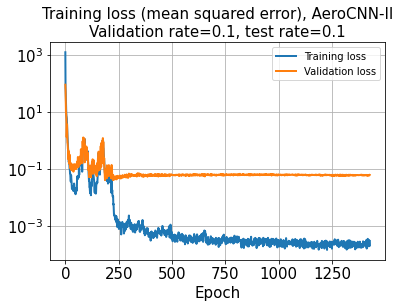

In [30]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error), AeroCNN-II\nValidation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

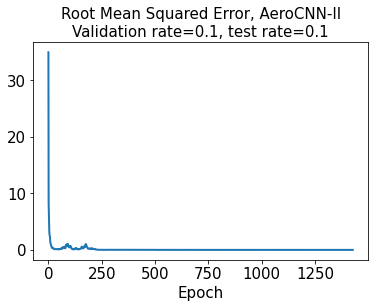

In [31]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\nValidation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

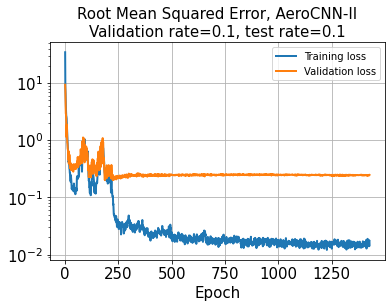

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\nValidation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [33]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 6ms/step - loss: 2.7779e-04 - rmse: 0.0167


In [34]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 36ms/step - loss: 0.0252 - rmse: 0.1586


In [35]:
decoded_train = model.predict(x_train)
decoded_val = model.predict(x_val)
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


In [36]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_AeroCNN_II_val"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [37]:
error_train_abs = np.abs(decoded_train - y_train)

In [38]:
error_val_abs = np.abs(decoded_val - y_val)

In [39]:
error_test_abs = np.abs(decoded_test - y_test)

In [40]:
os.chdir(storage_dir)

In [41]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.019518227276560295


In [42]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.2886019616793527


In [43]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.1833285051718139


In [44]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.34207373173096306


In [45]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.01484468488463678


In [46]:
l2_error_Cd_val = np.sqrt(np.sum((decoded_val[:,0] - y_val[:,0])**2) / np.sum(y_val[:,0]**2))
print(l2_error_Cd_val)

3.2777577296623166


In [47]:
l2_error_Cl_val = np.sqrt(np.sum((decoded_val[:,1] - y_val[:,1])**2) / np.sum(y_val[:,1]**2))
print(l2_error_Cl_val)

0.2647317016436384


In [48]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

3.4024315336647883


In [49]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.14820741192479706


In [50]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [51]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [52]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [53]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [54]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [55]:
l2_error_val_Cd_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cd_data = np.sqrt(np.sum((decoded_val[i][0] - y_val[i][0])**2) / np.sum(y_val[i][0]**2))
    l2_error_val_Cd_list.append(l2_error_val_Cd_data)

In [56]:
l2_error_val_Cl_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cl_data = np.sqrt(np.sum((decoded_val[i][1] - y_val[i][1])**2) / np.sum(y_val[i][1]**2))
    l2_error_val_Cl_list.append(l2_error_val_Cl_data)

In [57]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [58]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

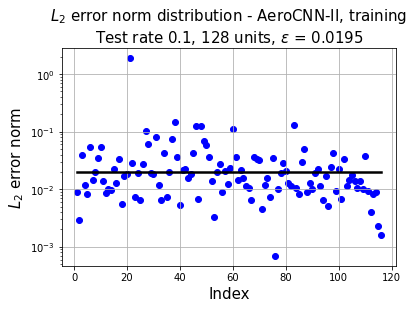

In [59]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

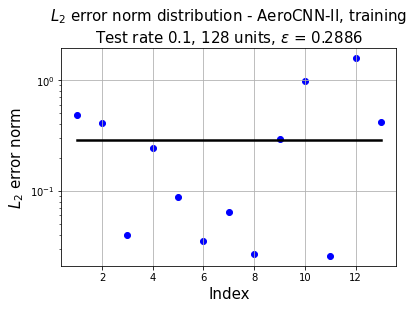

In [60]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_val), fontsize=15)
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

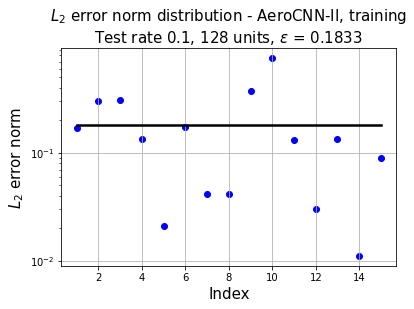

In [61]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

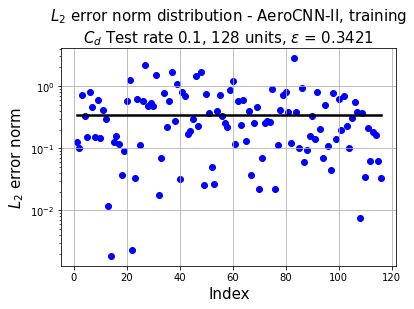

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

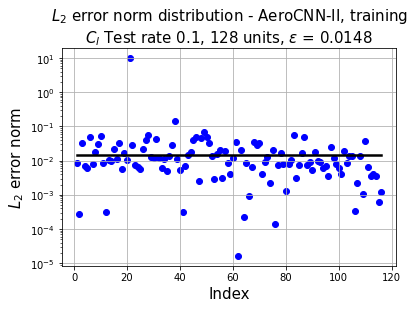

In [63]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

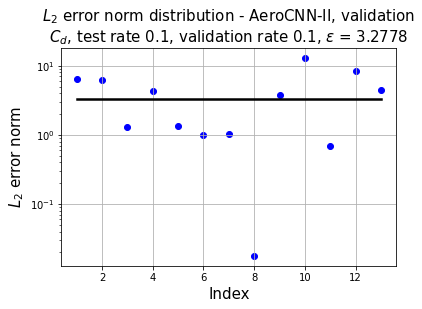

In [64]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cd_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, validation\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                                            val_rate,
                                                                                                                                            l2_error_Cd_val), fontsize=15)
plt.grid()
saveName = "CdvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

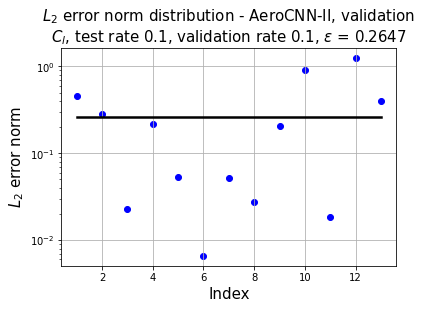

In [65]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cl_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, validation\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate, 
                                                                                                                                            val_rate,
                                                                                                                                            l2_error_Cl_val), fontsize=15)
plt.grid()
saveName = "ClvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

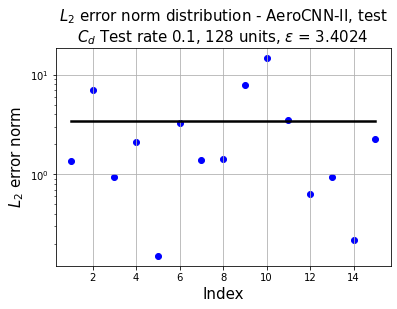

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

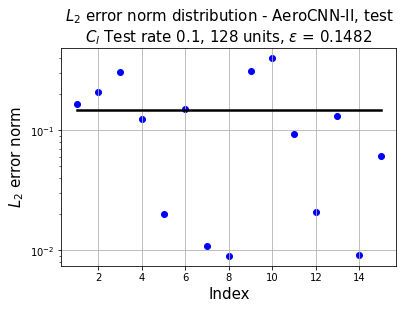

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()